In [1]:
!pip install category_encoders
!pip install eli5
!pip install xgboost
!pip install shap
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt
import shap

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from category_encoders import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Diamond/Diamonds Prices2022.csv')

df

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53939,53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64
53940,53941,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53941,53942,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43


In [5]:
df.isnull().value_counts()

Unnamed: 0  carat  cut    color  clarity  depth  table  price  x      y      z    
False       False  False  False  False    False  False  False  False  False  False    53943
dtype: int64

In [6]:
df=df.drop('Unnamed: 0',axis=1)

df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53939,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64
53940,0.71,Premium,E,SI1,60.5,55.0,2756,5.79,5.74,3.49
53941,0.71,Premium,F,SI1,59.8,62.0,2756,5.74,5.73,3.43


In [7]:
print(df.cut.unique())
print(df.color.unique())
print(df.clarity.unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


중복값 확인 및 제거

In [8]:
df.duplicated().value_counts()

False    53794
True       149
dtype: int64

In [9]:
df=df.drop_duplicates(ignore_index=True)

In [10]:
df.duplicated().value_counts()

False    53794
dtype: int64

In [11]:
df.isnull().value_counts()

carat  cut    color  clarity  depth  table  price  x      y      z    
False  False  False  False    False  False  False  False  False  False    53794
dtype: int64

In [12]:
target='price' # 연속성을 띄므로 회귀 문제로 푼다.

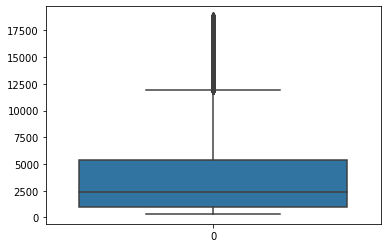

In [13]:
sb.boxplot(data=df[target])

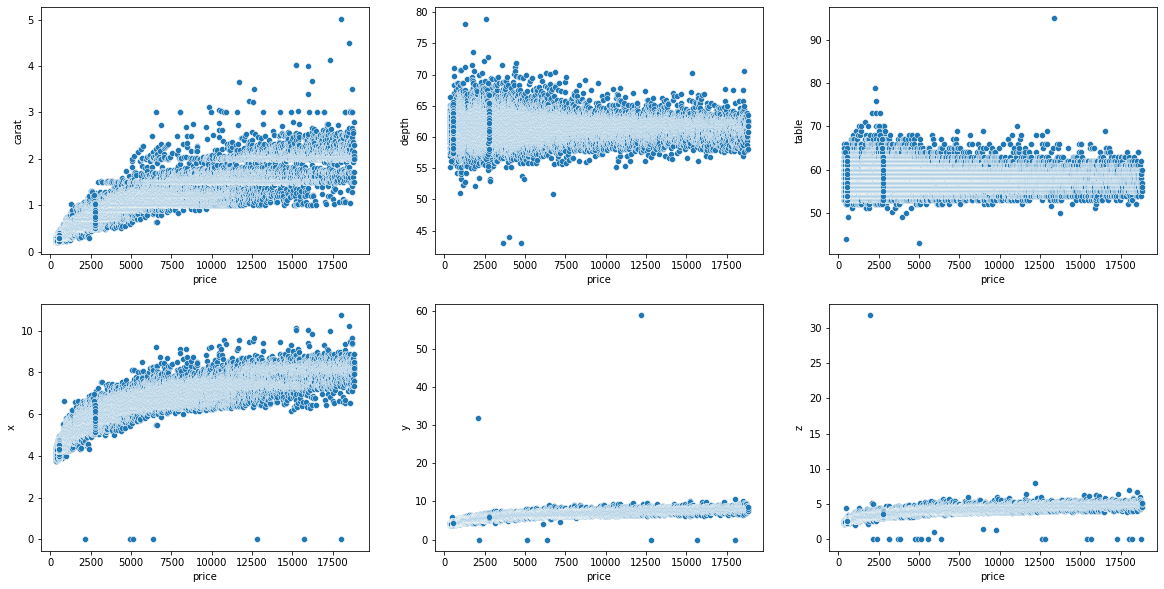

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

sb.scatterplot(data=df,x='price',y='carat',ax=ax[0][0])
sb.scatterplot(data=df,x='price',y='depth',ax=ax[0][1])
sb.scatterplot(data=df,x='price',y='table',ax=ax[0][2]);
sb.scatterplot(data=df,x='price',y='x',ax=ax[1][0]);
sb.scatterplot(data=df,x='price',y='y',ax=ax[1][1]);
sb.scatterplot(data=df,x='price',y='z',ax=ax[1][2]);

이상치를 제거한다.

In [15]:
dfc=df.copy()

iqr_target=dfc[target].quantile(0.75)-dfc[target].quantile(0.25)

iqr_carat=dfc.carat.quantile(0.75)-dfc.carat.quantile(0.25)
iqr_depth=dfc.depth.quantile(0.75)-dfc.depth.quantile(0.25)
iqr_table=dfc.table.quantile(0.75)-dfc.table.quantile(0.25)
iqr_x=dfc.x.quantile(0.75)-dfc.x.quantile(0.25)
iqr_y=dfc.y.quantile(0.75)-dfc.y.quantile(0.25)
iqr_z=dfc.z.quantile(0.75)-dfc.z.quantile(0.25)

dfc=dfc[dfc[target]<(dfc[target].quantile(0.75)+1.5*iqr_target)]
dfc=dfc[dfc[target]>(dfc[target].quantile(0.25)-1.5*iqr_target)]

dfc=dfc[dfc.carat<(dfc.carat.quantile(0.75)+1.5*iqr_carat)]
dfc=dfc[dfc.carat>(dfc.carat.quantile(0.25)-1.5*iqr_carat)]

dfc=dfc[dfc.depth<(dfc.depth.quantile(0.75)+1.5*iqr_depth)]
dfc=dfc[dfc.depth>(dfc.depth.quantile(0.25)-1.5*iqr_depth)]

dfc=dfc[dfc.table<(dfc.table.quantile(0.75)+1.5*iqr_table)]
dfc=dfc[dfc.table>(dfc.table.quantile(0.25)-1.5*iqr_table)]

dfc=dfc[dfc.x<(dfc.x.quantile(0.75)+1.5*iqr_x)]
dfc=dfc[dfc.x>(dfc.x.quantile(0.25)-1.5*iqr_x)]

dfc=dfc[dfc.y<(dfc.y.quantile(0.75)+1.5*iqr_y)]
dfc=dfc[dfc.y>(dfc.y.quantile(0.25)-1.5*iqr_y)]

dfc=dfc[dfc.z<(dfc.z.quantile(0.75)+1.5*iqr_z)]
dfc=dfc[dfc.z>(dfc.z.quantile(0.25)-1.5*iqr_z)]

dfc.shape

(47376, 10)

In [16]:
dfc.describe()

,carat,depth,table,price,x,y,z
count,47376.000000,47376.000000,47376.000000,47376.000000,47376.000000,47376.000000,47376.000000
mean,0.707881,61.785750,57.260482,3106.322378,5.545347,5.550265,3.427549
std,0.369323,1.105743,2.020859,2744.248457,0.977509,0.971721,0.604680
min,0.200000,58.800000,52.000000,326.000000,3.730000,3.680000,1.410000
25%,0.380000,61.100000,56.000000,891.000000,4.640000,4.650000,2.860000
50%,0.600000,61.900000,57.000000,2061.000000,5.440000,5.460000,3.360000
75%,1.010000,62.500000,59.000000,4631.250000,6.410000,6.410000,3.980000
max,1.960000,64.700000,63.400000,11888.000000,8.100000,8.210000,5.060000


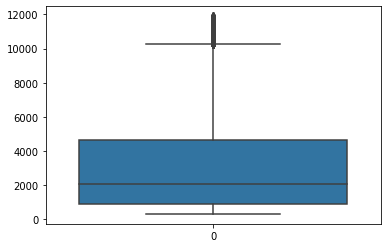

In [17]:
sb.boxplot(data=dfc[target])

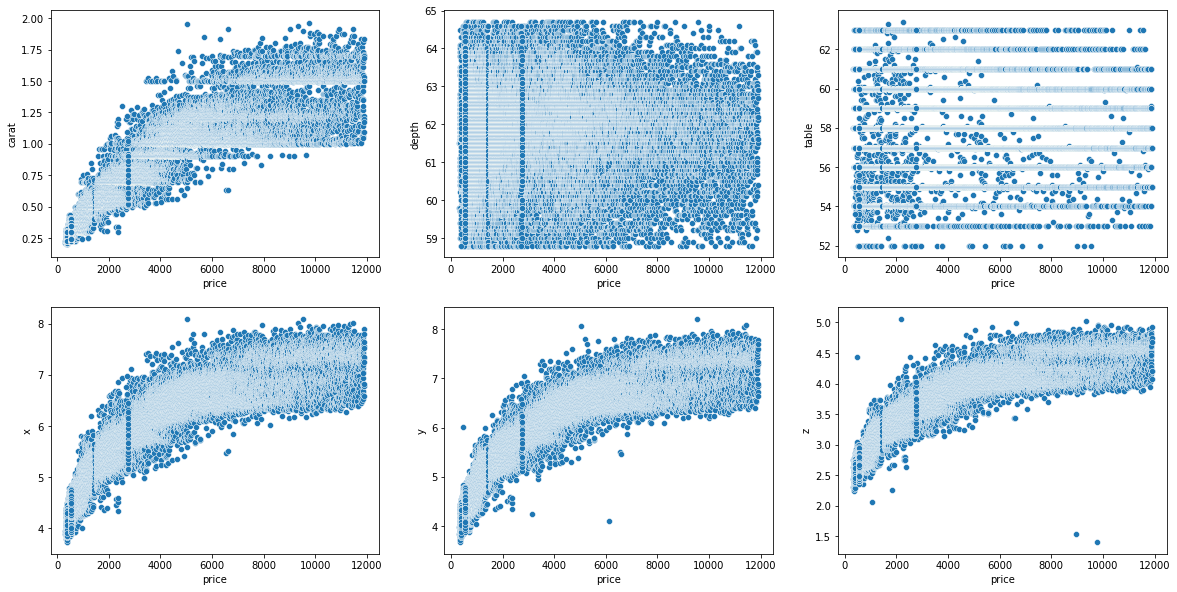

In [18]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

sb.scatterplot(data=dfc,x='price',y='carat',ax=ax[0][0])
sb.scatterplot(data=dfc,x='price',y='depth',ax=ax[0][1])
sb.scatterplot(data=dfc,x='price',y='table',ax=ax[0][2]);
sb.scatterplot(data=dfc,x='price',y='x',ax=ax[1][0]);
sb.scatterplot(data=dfc,x='price',y='y',ax=ax[1][1]);
sb.scatterplot(data=dfc,x='price',y='z',ax=ax[1][2]);

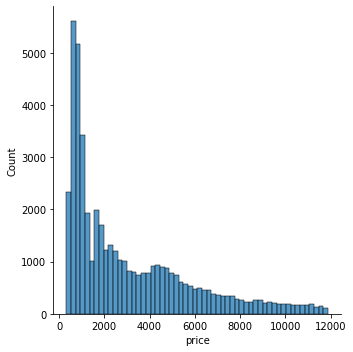

In [19]:
sb.displot(dfc[target]);

target이 right-skewed 상태이므로 로그변환을 통해 정규분포형태에 가깝게 변환시킨다.

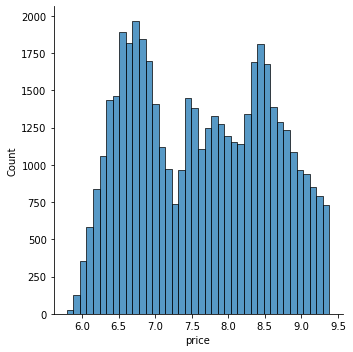

In [20]:
dfc[target]=np.log1p(dfc[target])
sb.displot(dfc[target]);

train, val, test set으로 data를 분리한다.

In [21]:
train, test=train_test_split(dfc,test_size=0.2)

train, val=train_test_split(train,test_size=0.2)

X_train=train.drop(target,axis=1)
y_train=train[target]
X_val=val.drop(target,axis=1)
y_val=val[target]
X_test=test.drop(target,axis=1)
y_test=test[target]

기준모델 평가

In [22]:
basepredict=y_test.mean()
y_base = [basepredict] * len(y_test)

print('mse : ',mean_squared_error(y_test,y_base))
print('mae : ',mean_absolute_error(y_test,y_base))
print('r2 : ',r2_score(y_test,y_base))

mse :  0.8544799537413915
mae :  0.8084930454872913
r2 :  0.0


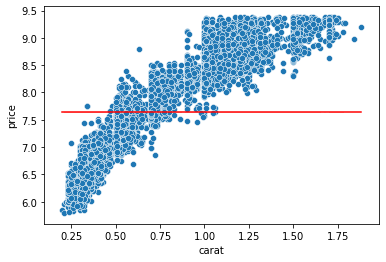

In [23]:
sb.lineplot(x=X_test.carat, y=basepredict, color='red')
sb.scatterplot(x=X_test.carat, y=y_test);

다중선형회귀 모델

In [24]:
linear = Pipeline([
    ('ord', OrdinalEncoder(mapping=[{'col':'cut','mapping':{'Fair':0,'Good':1,'Very Good':2,'Premium':3,'Ideal':4}},
                                    {'col':'color','mapping':{'J':0,'I':1,'H':2,'G':3,'F':4,'E':5,'D':6}},
                                    {'col':'clarity','mapping':{'I1':0,'SI2':1,'SI1':2,'VS2':3,'VS1':4,'VVS2':5,'VVS1':6,'IF':7}}])),
    ('line', LinearRegression())])

linear.fit(X_train,y_train)

y_val_pred_linear=linear.predict(X_val)

In [25]:
coefficients= linear.named_steps['line'].coef_
pd.Series(coefficients, X_train.columns)

carat     -1.079590
cut        0.023158
color      0.076321
clarity    0.117611
depth      0.050722
table      0.009961
x          0.940317
y          0.336693
z          0.229098
dtype: float64

상관계수 시각화

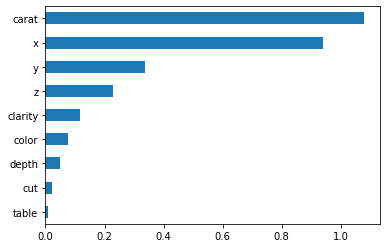

In [26]:
pd.Series(coefficients, X_train.columns).abs().sort_values().plot.barh();

In [27]:
print('mse : ',mean_squared_error(y_val,y_val_pred_linear))
print('mae : ',mean_absolute_error(y_val,y_val_pred_linear))
print('r2 : ',r2_score(y_val,y_val_pred_linear))

mse :  0.019016886053439867
mae :  0.10777529522751357
r2 :  0.9774416928438422


In [28]:
y_test_pred_linear=linear.predict(X_test)

print('mse : ',mean_squared_error(y_test,y_test_pred_linear))
print('mae : ',mean_absolute_error(y_test,y_test_pred_linear))
print('r2 : ',r2_score(y_test,y_test_pred_linear))

mse :  0.019601820143621405
mae :  0.10909639514896644
r2 :  0.9770599414792662


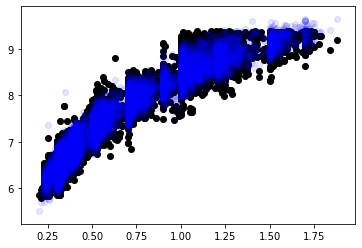

In [29]:
plt.scatter(X_test.carat, y_test, color='black')
# plt.scatter(X_val.carat, y_val_pred_linear, color='red', linewidth=1)
plt.scatter(X_test.carat, y_test_pred_linear, color='blue',alpha=0.1);

Boosting 모델

In [30]:
boosting = XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    learning_rate=0.2,
    n_jobs=-1
)

X_train_enc=linear.named_steps['ord'].transform(X_train)
X_val_enc=linear.named_steps['ord'].transform(X_val)
X_test_enc=linear.named_steps['ord'].transform(X_test)

eval_set=[(X_train_enc,y_train),(X_val_enc,y_val)]

boosting.fit(X_train_enc,y_train,eval_set=eval_set,early_stopping_rounds=50)

[0]	validation_0-rmse:5.76132	validation_1-rmse:5.75656
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.61167	validation_1-rmse:4.60881
[2]	validation_0-rmse:3.69225	validation_1-rmse:3.69019
[3]	validation_0-rmse:2.95714	validation_1-rmse:2.95632
[4]	validation_0-rmse:2.36942	validation_1-rmse:2.36854
[5]	validation_0-rmse:1.89972	validation_1-rmse:1.89922
[6]	validation_0-rmse:1.52448	validation_1-rmse:1.52455
[7]	validation_0-rmse:1.22494	validation_1-rmse:1.22498
[8]	validation_0-rmse:0.985682	validation_1-rmse:0.985795
[9]	validation_0-rmse:0.795319	validation_1-rmse:0.79618
[10]	validation_0-rmse:0.643876	validation_1-rmse:0.644962
[11]	validation_0-rmse:0.523854	validation_1-rmse:0.52496
[12]	validation_0-rmse:0.428996	validation_1-rmse:0.430446
[13]	validation_0-rmse:0.354255	validation_1-rmse:0.355795
[14]	validation_0-rmse:0.296161	validation_

XGBRegressor(learning_rate=0.2, n_jobs=-1, objective='reg:squarederror')

In [31]:
y_val_pred_boosting=boosting.predict(X_val_enc)

print('mse : ',mean_squared_error(y_val,y_val_pred_boosting))
print('mae : ',mean_absolute_error(y_val,y_val_pred_boosting))
print('r2 : ',r2_score(y_val,y_val_pred_boosting))

mse :  0.00863353131907571
mae :  0.07041947172971827
r2 :  0.9897586886312131


In [32]:
y_test_pred_boosting=boosting.predict(X_test_enc)

print('mse : ',mean_squared_error(y_test,y_test_pred_boosting))
print('mae : ',mean_absolute_error(y_test,y_test_pred_boosting))
print('r2 : ',r2_score(y_test,y_test_pred_boosting))

mse :  0.008555763000183807
mae :  0.07009065993807184
r2 :  0.9899871694324461


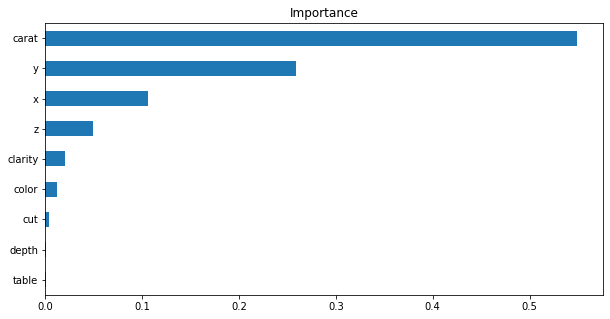

In [33]:
importances = pd.Series(boosting.feature_importances_, X_train.columns)

n = 9
plt.figure(figsize=(10,5))
plt.title('Importance')
importances.sort_values()[-n:].plot.barh();

In [34]:
def pdpplotprint(model,dataset,model_features,feature):
  isolated=pdp_isolate(model=model,dataset=dataset,model_features=model_features,
                       feature=feature,grid_type='percentile',num_grid_points=10)
  return pdp_plot(isolated,feature_name=feature)

In [35]:
param_distributions = { 
    'n_estimators': range(10, 200), 
    'max_depth': range(3,20), 
    'min_samples_leaf':range(1,10),
    'min_samples_split':range(1,10)
}

rscv = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=11
)

rscv.fit(X_train_enc,y_train)

rscv.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'max_depth': 16,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 197}

In [36]:
# param_grid = { 
#     'n_estimators': range(80, 150), 
#     'max_depth': range(13,20), 
#     'min_samples_leaf':range(1,6),
#     'min_samples_split':range(1,10)
# }

# rscv_final=GridSearchCV(RandomForestRegressor(random_state=2), 
#     param_grid=param_grid,     
#     scoring='neg_mean_absolute_error', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1,     
# )

# rscv_final.fit(X_train_enc,y_train)

# rscv_final.best_params_

In [37]:
rf_cv=rscv.best_estimator_

rf_cv.fit(X_train_enc,y_train)

RandomForestRegressor(max_depth=16, min_samples_leaf=3, n_estimators=197,
                      random_state=2)

In [46]:
y_val_pred_rf_cv=rf_cv.predict(X_val_enc)

print('mse : ',mean_squared_error(y_val,y_val_pred_rf_cv))
print('mae : ',mean_absolute_error(y_val,y_val_pred_rf_cv))
print('r2 : ',r2_score(y_val,y_val_pred_rf_cv))

mse :  0.007308447211523517
mae :  0.06120830860222889
r2 :  0.9913305366310332


In [47]:
y_test_pred_rf_cv=rf_cv.predict(X_test_enc)

print('mse : ',mean_squared_error(y_test,y_test_pred_rf_cv))
print('mae : ',mean_absolute_error(y_test,y_test_pred_rf_cv))
print('r2 : ',r2_score(y_test,y_test_pred_rf_cv))

mse :  0.00714248417131976
mae :  0.06092930517398254
r2 :  0.9916411331359548


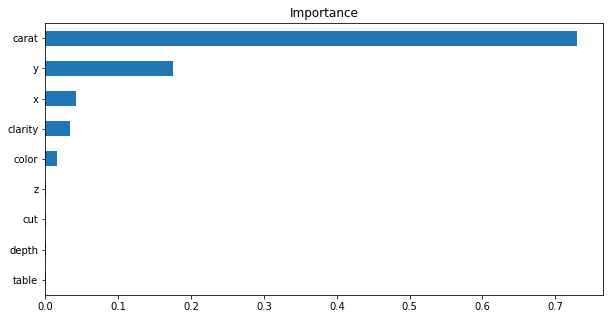

In [40]:
importances = pd.Series(rf_cv.feature_importances_, X_train.columns)

n = 9
plt.figure(figsize=(10,5))
plt.title('Importance')
importances.sort_values()[-n:].plot.barh();

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc870e464d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc86f4eb390>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


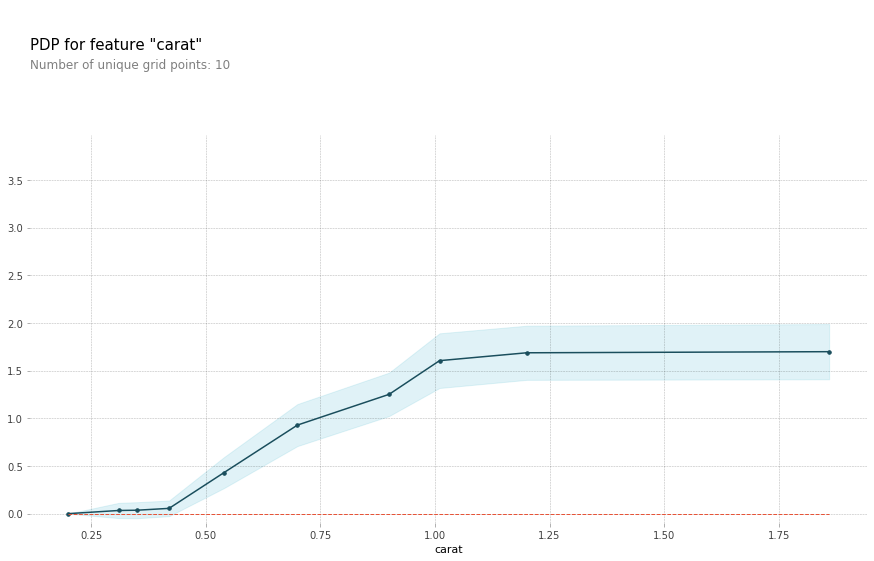

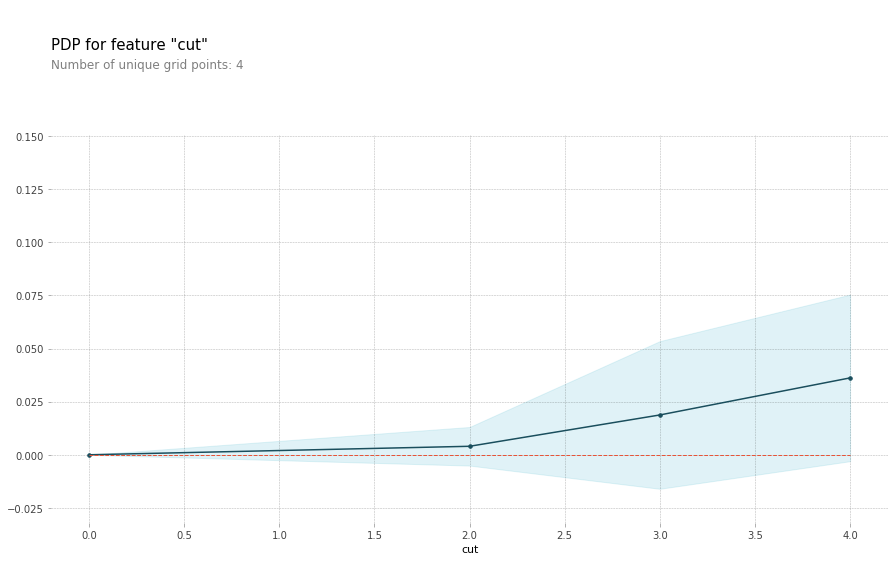

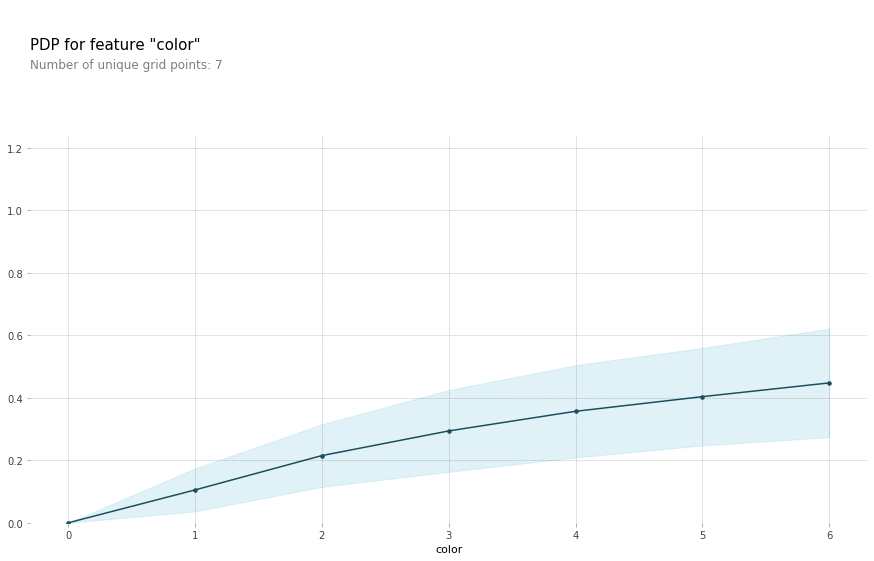

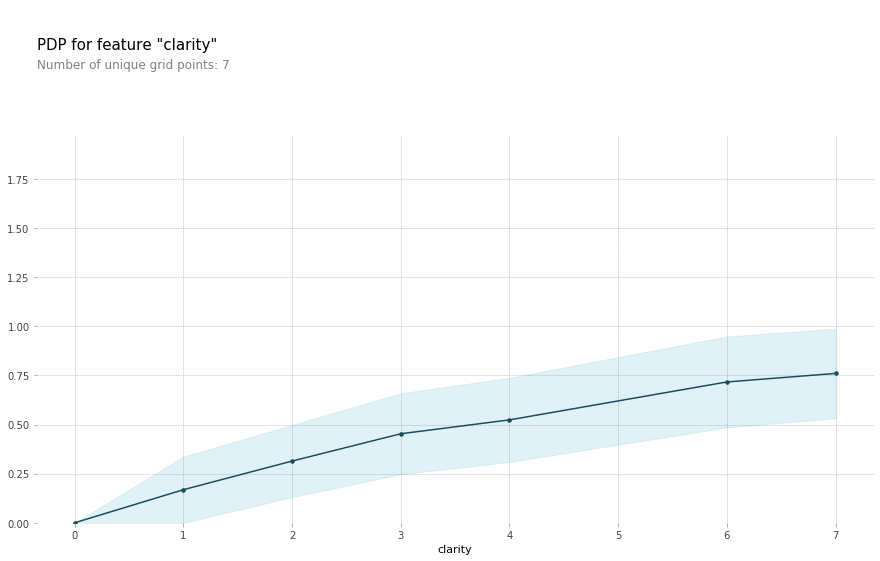

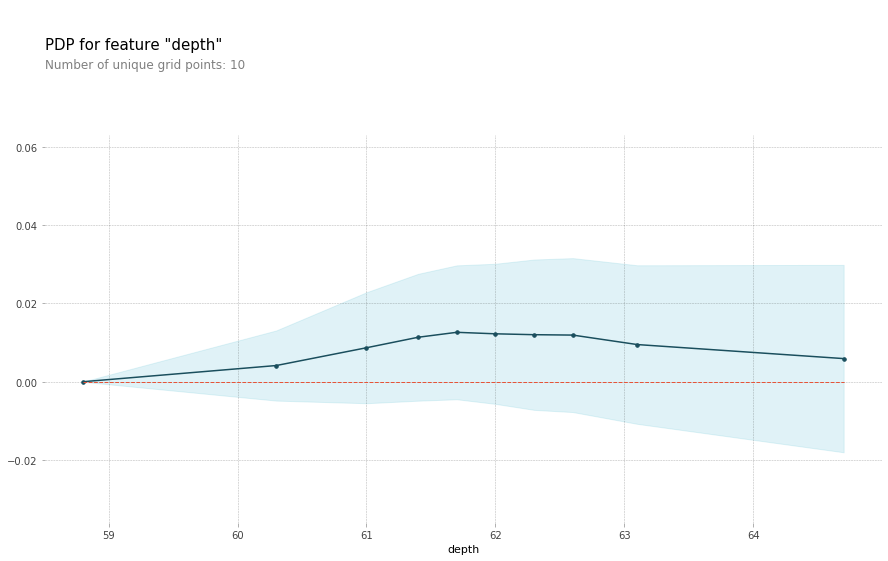

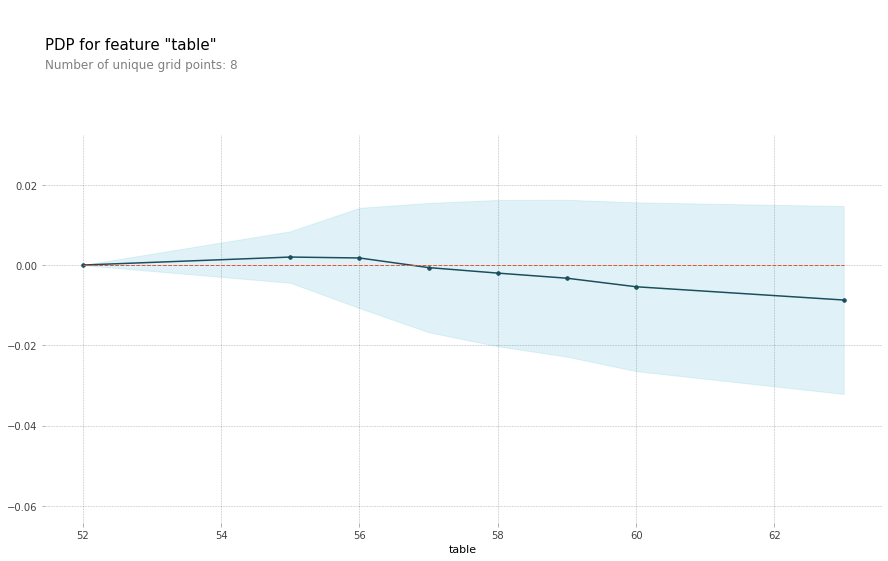

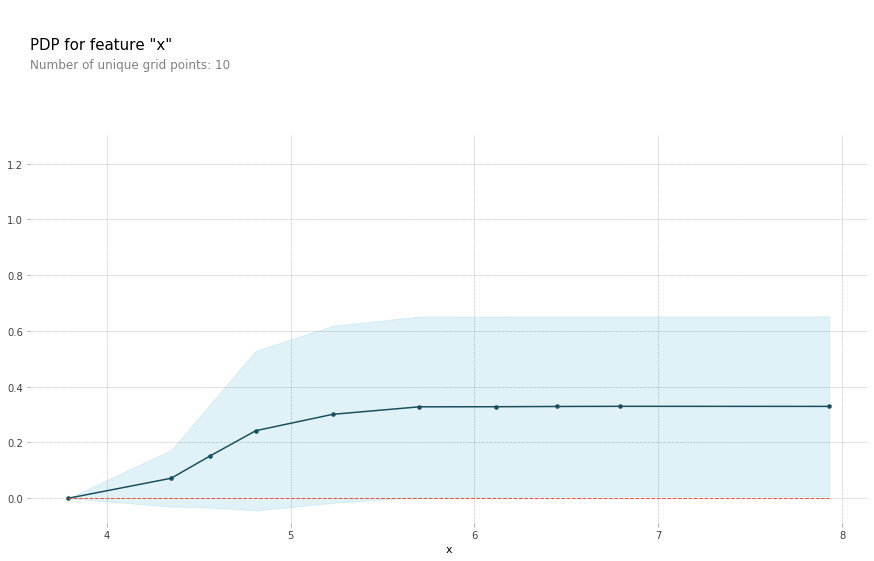

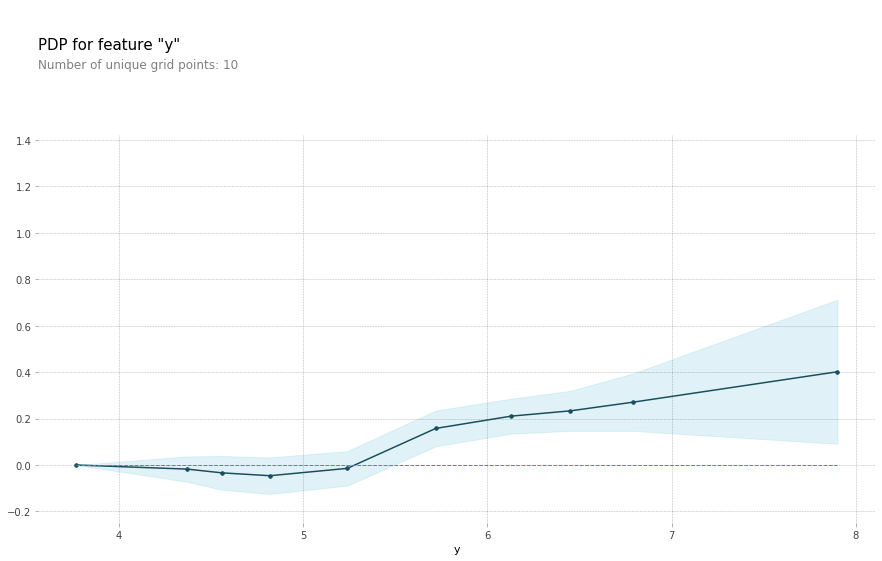

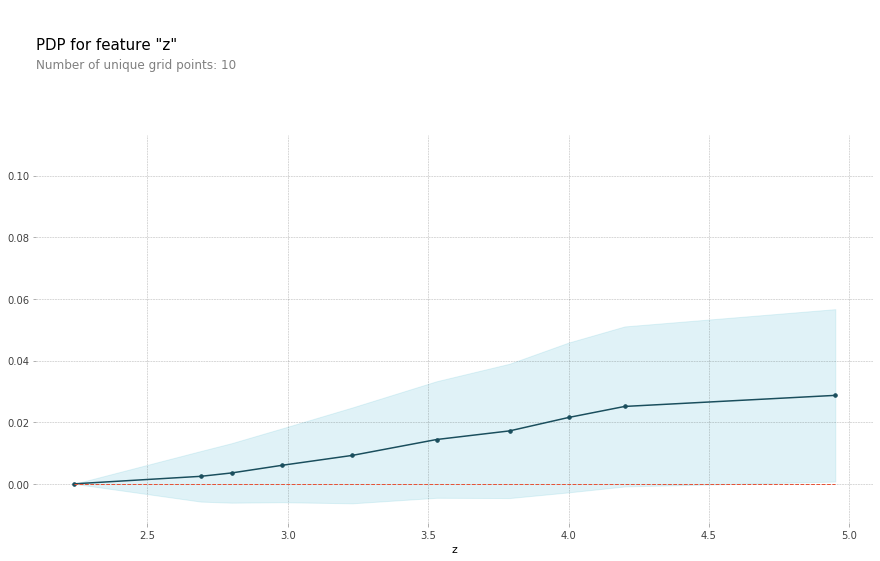

In [41]:
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'carat')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'cut')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'color')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'clarity')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'depth')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'table')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'x')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'y')
pdpplotprint(rf_cv,X_val_enc,X_val_enc.columns,'z')

In [42]:
explainer = shap.TreeExplainer(rf_cv)
shap_values = explainer.shap_values(X_test_enc.iloc[:300])

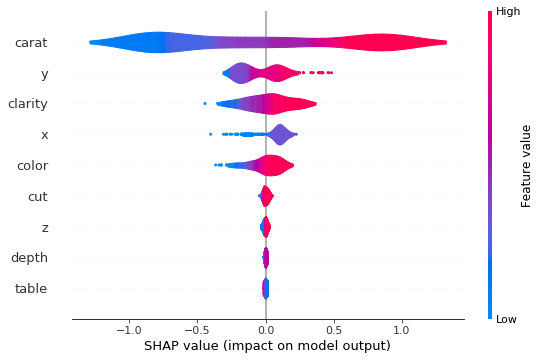

In [43]:
shap.summary_plot(shap_values, X_test_enc.iloc[:300], plot_type="violin")

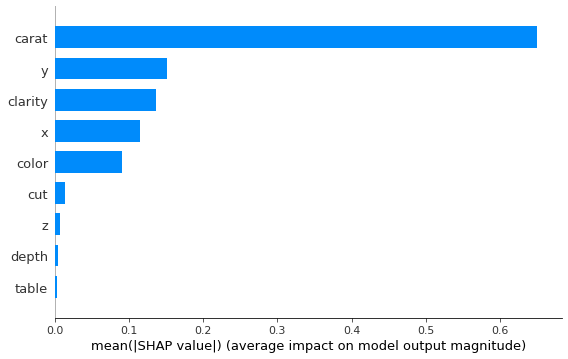

In [44]:
shap.summary_plot(shap_values, X_test_enc.iloc[:300], plot_type="bar")

In [48]:
mse=[mean_squared_error(y_test,y_base),mean_squared_error(y_test,y_test_pred_linear),mean_squared_error(y_test,y_test_pred_boosting),mean_squared_error(y_test,y_test_pred_rf_cv)]
mae=[mean_absolute_error(y_test,y_base),mean_absolute_error(y_test,y_test_pred_linear),mean_absolute_error(y_test,y_test_pred_boosting),mean_absolute_error(y_test,y_test_pred_rf_cv)]
r2=[r2_score(y_test,y_base),r2_score(y_test,y_test_pred_linear),r2_score(y_test,y_test_pred_boosting),r2_score(y_test,y_test_pred_rf_cv)]

result=pd.DataFrame(index=['base','linear','boosting','randomforest'],columns=['mse','mae','r2'])

result.mse=mse
result.mae=mae
result.r2=r2

result


,mse,mae,r2
base,0.854480,0.808493,0.000000
linear,0.019602,0.109096,0.977060
boosting,0.008556,0.070091,0.989987
randomforest,0.007142,0.060929,0.991641
